In [3]:
# Mengimpor pustaka yang diperlukan
import numpy as np               # Untuk operasi numerik
import pandas as pd              # Untuk manipulasi dan analisis data menggunakan DataFrame
import matplotlib.pyplot as plt  # Untuk visualisasi data

import tensorflow as tf          # Untuk pembuatan dan pelatihan model deep learning
import tensorflow_hub as hub     # Untuk menggunakan pre-trained models dari TensorFlow Hub
from tensorflow.keras.callbacks import TensorBoard  # Untuk menggunakan TensorBoard sebagai callback dalam pelatihan model

In [4]:
# Membuat objek TensorBoard callback untuk melacak performa model selama pelatihan
tensorboard_callback = TensorBoard(log_dir='./logs')

In [5]:
# Membaca file CSV 'wine-reviews.csv' ke dalam DataFrame menggunakan Pandas
# Memuat kolom-kolom tertentu: 'country', 'description', 'points', 'price', 'variety', 'winery'
df = pd.read_csv("wine-reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])


In [7]:
df.head()


,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [8]:
# Menghapus baris yang memiliki nilai kosong (NaN) di kolom "description" dan "points" dari DataFrame df
df = df.dropna(subset=["description", "points"])


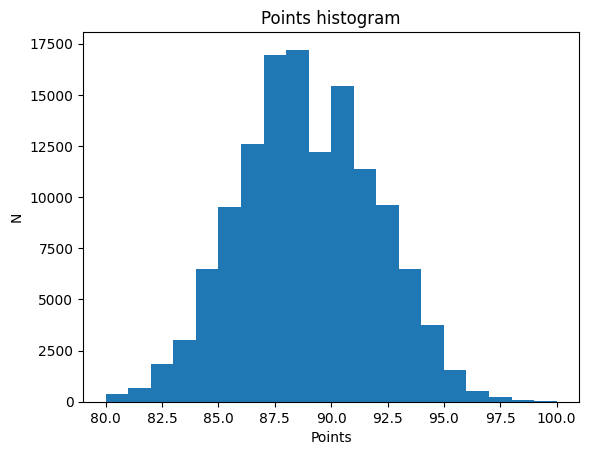

In [9]:
# Membuat histogram menggunakan matplotlib untuk kolom 'points' dari DataFrame df
# dengan membaginya ke dalam 20 bins
plt.hist(df.points, bins=20)

# Menambahkan judul ke dalam histogram
plt.title("Points histogram")

# Memberikan label pada sumbu-y
plt.ylabel("N")

# Memberikan label pada sumbu-x
plt.xlabel("Points")

# Menampilkan histogram
plt.show()


In [10]:
# Menambahkan kolom 'label' ke dalam DataFrame df dengan menggunakan kondisi
# Jika nilai kolom 'points' >= 90, maka 'label' akan bernilai 1 (True), jika tidak, akan bernilai 0 (False)
df["label"] = (df.points >= 90).astype(int)

# Memilih hanya kolom 'description' dan 'label' dari DataFrame df
df = df[["description", "label"]]


In [11]:
# Memisahkan DataFrame 'df' menjadi tiga bagian: data latih (train), validasi (val), dan pengujian (test)
# df.sample(frac=1) mengacak urutan baris dalam DataFrame sebelum pembagian

# Pembagian dilakukan dengan proporsi:
# 80% data untuk pelatihan (train)
# 10% data untuk validasi (val)
# 10% data untuk pengujian (test)
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])


/home/prehsiat/Documents/Tugas-2-Kecerdasan-Artifisial-21081070100600/env/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  # Salin DataFrame agar tidak mengubah DataFrame asli
  df = dataframe.copy()

  # Ambil kolom 'label' sebagai target variabel yang akan diprediksi
  labels = df.pop('label')

  # Hanya ambil kolom 'description' sebagai fitur input
  df = df["description"]

  # Buat dataset dari fitur dan label menggunakan tf.data.Dataset.from_tensor_slices
  ds = tf.data.Dataset.from_tensor_slices((df, labels))

  # Jika shuffle=True, acak dataset
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))

  # Kelompokkan data menjadi batch berukuran batch_size
  ds = ds.batch(batch_size)

  # Menggunakan prefetch untuk memastikan data siap sedia saat pelatihan
  ds = ds.prefetch(tf.data.AUTOTUNE)

  # Kembalikan dataset yang telah dibuat
  return ds


In [13]:
# Membuat dataset untuk data pelatihan (train), validasi (val), dan pengujian (test)
train_data = df_to_dataset(train)  # Dataset untuk data pelatihan
valid_data = df_to_dataset(val)    # Dataset untuk data validasi
test_data = df_to_dataset(test)    # Dataset untuk data pengujian


#Embedding + Model

In [15]:
# URL untuk model embedding yang digunakan dari TensorFlow Hub
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

# Membuat layer menggunakan KerasLayer dari TensorFlow Hub
# Menggunakan URL embedding yang telah disebutkan, dengan tipe data tf.string
# Trainable=True memungkinkan pembelajaran embedding untuk disesuaikan dengan data saat pelatihan
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)


2023-11-26 16:12:25.057498: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 192762400 exceeds 10% of free system memory.


In [16]:
# Membuat model Sequential dari TensorFlow Keras
model = tf.keras.Sequential()

# Menambahkan layer embedding yang sudah dipersiapkan sebelumnya dari TensorFlow Hub
model.add(hub_layer)

# Menambahkan layer Dense (fully connected) dengan 16 unit neuron dan fungsi aktivasi ReLU
model.add(tf.keras.layers.Dense(16, activation='relu'))

# Menambahkan layer Dropout untuk mengurangi overfitting dengan tingkat dropout 40%
model.add(tf.keras.layers.Dropout(0.4))

# Menambahkan layer Dense kedua dengan 16 unit neuron dan fungsi aktivasi ReLU
model.add(tf.keras.layers.Dense(16, activation='relu'))

# Menambahkan layer Dropout kedua dengan tingkat dropout 40%
model.add(tf.keras.layers.Dropout(0.4))

# Layer output dengan satu unit neuron dan fungsi aktivasi sigmoid untuk klasifikasi biner
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


In [17]:
# Mengompilasi model menggunakan optimizer, fungsi loss, dan metrik yang spesifik
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Optimizer Adam dengan learning rate 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),  # Fungsi loss Binary Crossentropy untuk masalah klasifikasi biner
    metrics=['accuracy']  # Metrik evaluasi yang dihitung selama pelatihan: akurasi
)


In [20]:
# Melatih model dengan data latih (train_data) selama 5 epochs
# Menggunakan data validasi (valid_data) untuk evaluasi setiap epoch
# Callback TensorBoard digunakan untuk melacak performa model selama pelatihan
history = model.fit(
    train_data,  # Data latih
    epochs=7,  # Jumlah epochs yang akan dilatih
    validation_data=valid_data,  # Data validasi
    callbacks=[tensorboard_callback]  # Callback untuk TensorBoard
)


Epoch 1/7


102/102 [==============================] - 61s 592ms/step - loss: 0.3180 - accuracy: 0.8679 - val_loss: 0.3779 - val_accuracy: 0.8314
Epoch 2/7
102/102 [==============================] - 61s 595ms/step - loss: 0.3022 - accuracy: 0.8759 - val_loss: 0.3837 - val_accuracy: 0.8342
Epoch 3/7
102/102 [==============================] - 61s 596ms/step - loss: 0.2890 - accuracy: 0.8835 - val_loss: 0.3917 - val_accuracy: 0.8324
Epoch 4/7
102/102 [==============================] - 61s 596ms/step - loss: 0.2764 - accuracy: 0.8898 - val_loss: 0.4039 - val_accuracy: 0.8300
Epoch 5/7
102/102 [==============================] - 61s 598ms/step - loss: 0.2659 - accuracy: 0.8940 - val_loss: 0.4114 - val_accuracy: 0.8325
Epoch 6/7
102/102 [==============================] - 61s 596ms/step - loss: 0.2538 - accuracy: 0.8993 - val_loss: 0.4257 - val_accuracy: 0.8309
Epoch 7/7
102/102 [==============================] - 61s 594ms/step - loss: 0.2445 - accuracy: 0.9034 - val_loss: 0.4451 - val_accuracy: 0.8325


In [21]:
# Melakukan evaluasi model menggunakan data pengujian (test_data)
evaluation_results = model.evaluate(test_data)

# Menampilkan nilai-nilai metrik evaluasi
print("Loss:", evaluation_results[0])  # Menampilkan nilai loss
print("Accuracy:", evaluation_results[1])  # Menampilkan nilai akurasi


13/13 [==============================] - 1s 99ms/step - loss: 0.4475 - accuracy: 0.8286
Loss: 0.4475235641002655
Accuracy: 0.8285890221595764


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


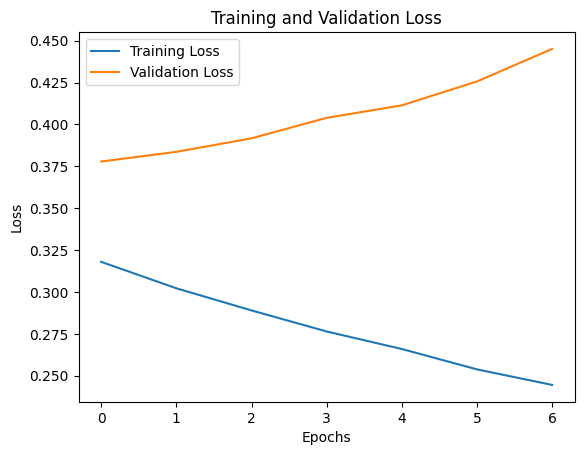

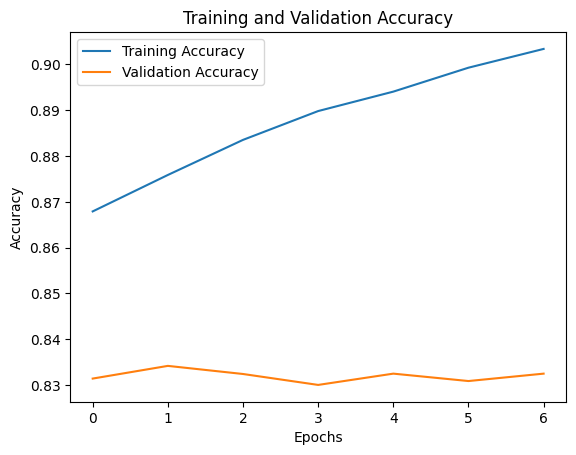

In [22]:
# Melihat metrik-metrik yang tersedia dari riwayat pelatihan
print(history.history.keys())

# Plot loss pada set pelatihan dan set validasi
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot akurasi pada set pelatihan dan set validasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48191705 (183.84 MB)
Trainable params: 481

In [24]:
# Simpan model ke dalam file .h5
model.save("ANNTugas2AI.h5")


/home/prehsiat/Documents/Tugas-2-Kecerdasan-Artifisial-21081070100600/env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
